# Using Epidemic Size

In [61]:
### import modules
import numpy as np
from utils import run_scenarios_size, plot_scenarios_size, run_modified_seir
import matplotlib.pyplot as plt

## Measured 30 Days After Vaccination

In [7]:
def _delta(t, tv):
    if (t > tv - 0.8) and (t < tv + 0.8):
        return 1
    else:
        return 0

In [28]:
def modified_seir(y, t, tv, beta, sigma, gamma, fv, epsL, epsA):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, v_s, v_r, e, i, r = y
    v = fv * _delta(t, tv)
    
    dsdt = - beta*s*i - v*s
    dvsdt = (1-epsA)*v*s - beta*v_s*i
    dvrdt = epsA*v*s - beta*(1-epsL)*v_r*i
    dedt = beta*(s+v_s+(1-epsL)*v_r)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return dsdt, dvsdt, dvrdt, dedt, didt, drdt

In [21]:
def seir_size(t, y, beta, sigma, gamma):
    """
    Basic SEIR model
    """
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return [dsdt, dedt, didt, drdt]

In [26]:
def seir (y, t, beta, sigma, gamma):
    """
    Basic SEIR model
    """
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return dsdt, dedt, didt, drdt

In [30]:
def _reach_size10(t, y, beta, sigma, gamma): return y[3] - 0.1
def _reach_size25(t, y, beta, sigma, gamma): return y[3] - 0.25

_reach_size10.terminate=True
_reach_size25.terminate=True

In [57]:
def modified_seir_ivp(t, y, tv, beta, sigma, gamma, fv, epsL, epsA):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, v_s, v_r, e, i, r = y
    v = fv * _delta(t, tv)
    
    dsdt = - beta*s*i - v*s
    dvsdt = (1-epsA)*v*s - beta*v_s*i
    dvrdt = epsA*v*s - beta*(1-epsL)*v_r*i
    dedt = beta*(s+v_s+(1-epsL)*v_r)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return [dsdt, dvsdt, dvrdt, dedt, didt, drdt]

In [65]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

def run_scenarios_size(y0: list, t: list, R0s: np.ndarray, sigma: float, gamma: float, \
    epss: np.ndarray, epidemic_size: int, measured: int): 
    s0, e0, i0, r0 = y0
    df_R0s = []; df_epss = []; df_fvs = []
    covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_covs = []
    df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []

    for R0 in R0s:
        beta = R0 * gamma
   
        for eps in epss:
            fc = 1/eps * (1 - 1/R0)
            for cov in covs:
                if cov == 'Below fc':
                    fv = fc * 0.8
                elif cov == 'Slightly Above fc':
                    fv = 1 - ((1 - fc) * 0.8)
                else:
                    fv = 1 - ((1 - fc) * 0.5)

                if epidemic_size == 0:
                    tv = -1; s0_vax = 0.98-fv 
                    t0 = np.linspace(0, measured, measured+1)

                    sim0 = odeint(seir, y0, t0, args=(beta, sigma, gamma))
                    _, _, _, r_novax = sim0.T

                    r_tot = r_novax[-1]
                
                    # leaky
                    vs0_leaky = 0; vr0_leaky = fv; y0_leaky = [s0_vax, vs0_leaky, vr0_leaky, e0, i0, r0]
                    sim_leaky = run_modified_seir(y0_leaky, t0, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

                    # aon
                    vs0_aon = fv*(1-eps); vr0_aon = fv*eps; y0_aon = [s0_vax, vs0_aon, vr0_aon, e0, i0, r0]
                    sim_aon = run_modified_seir(y0_aon, t0, tv, beta, sigma, gamma, fv, eps, mode = 'aon')   

                elif epidemic_size == 10:
                    vs0 = 0; vr0 = 0; y0_vax = [s0, vs0, vr0, e0, i0, r0]
                    sol = solve_ivp(seir_size, t, y0, args=(beta, sigma, gamma), events=_reach_size10, dense_output=True)
                    if np.array(sol.t_events).size == 0:
                        rmax_idx = np.argmax(np.array(sol.y[3]))
                        tv = np.array(sol.t)[rmax_idx]
                    else:
                        tv = float(np.array(sol.t_events))
                    t10 = np.linspace(0, int(tv+measured), int(tv+measured+1))

                    sim10 = odeint(seir, y0, t10, args=(beta, sigma, gamma))
                    _, _, _, r_novax = sim10.T

                    r_tot = r_novax[-1]

                    # leaky
                    sim_leaky = run_modified_seir(y0_vax, t10, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

                    # aon
                    sim_aon = run_modified_seir(y0_vax, t10, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
                
                elif epidemic_size == 25:
                    vs0 = 0; vr0 = 0; y0_vax = [s0, vs0, vr0, e0, i0, r0]
                    sol = solve_ivp(seir_size, t, y0, args=(beta, sigma, gamma), events=_reach_size25, dense_output=True)
                    if np.array(sol.t_events).size == 0:
                        rmax_idx = np.argmax(np.array(sol.y[3]))
                        tv = np.array(sol.t)[rmax_idx]
                    else:
                        tv = float(np.array(sol.t_events))
                    t25 = np.linspace(0, int(tv+measured), int(tv+measured+1))

                    sim25 = odeint(seir, y0, t25, args=(beta, sigma, gamma))
                    _, _, _, r_novax = sim25.T

                    r_tot = r_novax[-1]

                    # leaky
                    sim_leaky = run_modified_seir(y0_vax, t25, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

                    # aon
                    sim_aon = run_modified_seir(y0_vax, t25, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
                
                _, _, _, _, _, _, r_leaky = sim_leaky
                r_tot_leaky = r_leaky[-1]
                r_perc_leaky = (r_tot - r_tot_leaky) / r_tot * 100

                _, _, _, _, _, _, r_aon = sim_aon
                r_tot_aon = r_aon[-1]
                r_perc_aon = (r_tot - r_tot_aon) / r_tot * 100

                r_perc_diff = r_perc_aon - r_perc_leaky

                df_R0s.append(R0)
                df_epss.append(eps)
                df_fvs.append(fv)
                df_covs.append(cov)
                df_r_perc_leakys.append(r_perc_leaky)
                df_r_perc_aons.append(r_perc_aon)
                df_r_perc_diffs.append(r_perc_diff)

    # build dataframe                        
    data = {'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
        'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs}
    vax_df = pd.DataFrame(data=data)

    return vax_df

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:636: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


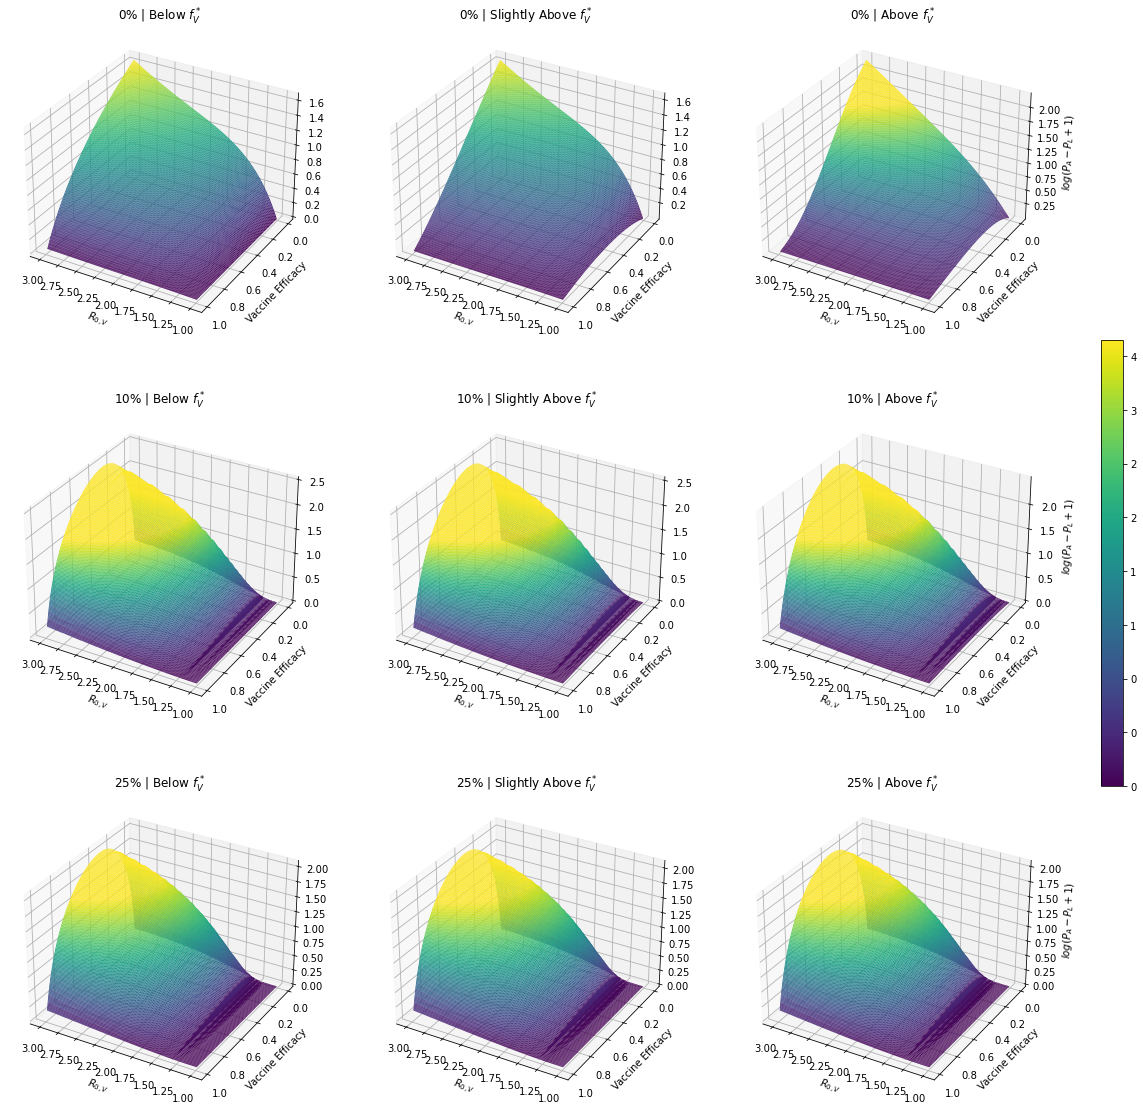

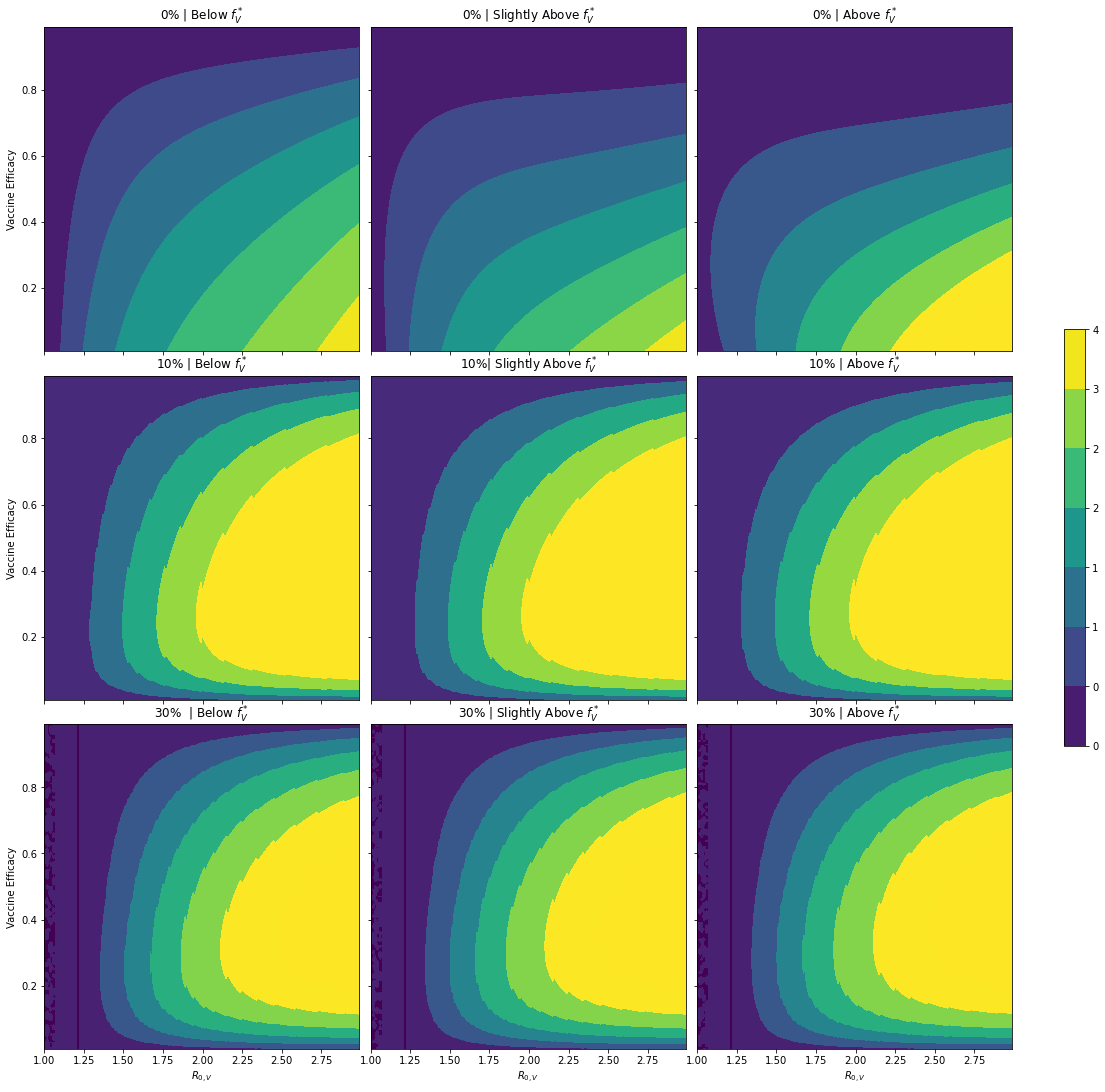

In [63]:
sigma = 1/4; gamma = 1/4; t = [0, 300]
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_30 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=0, measured=30)
epi10_df_30 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=10, measured=30)
epi25_df_30 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=25, measured=30)

fig_3d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 60 Days After Vaccination

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:636: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


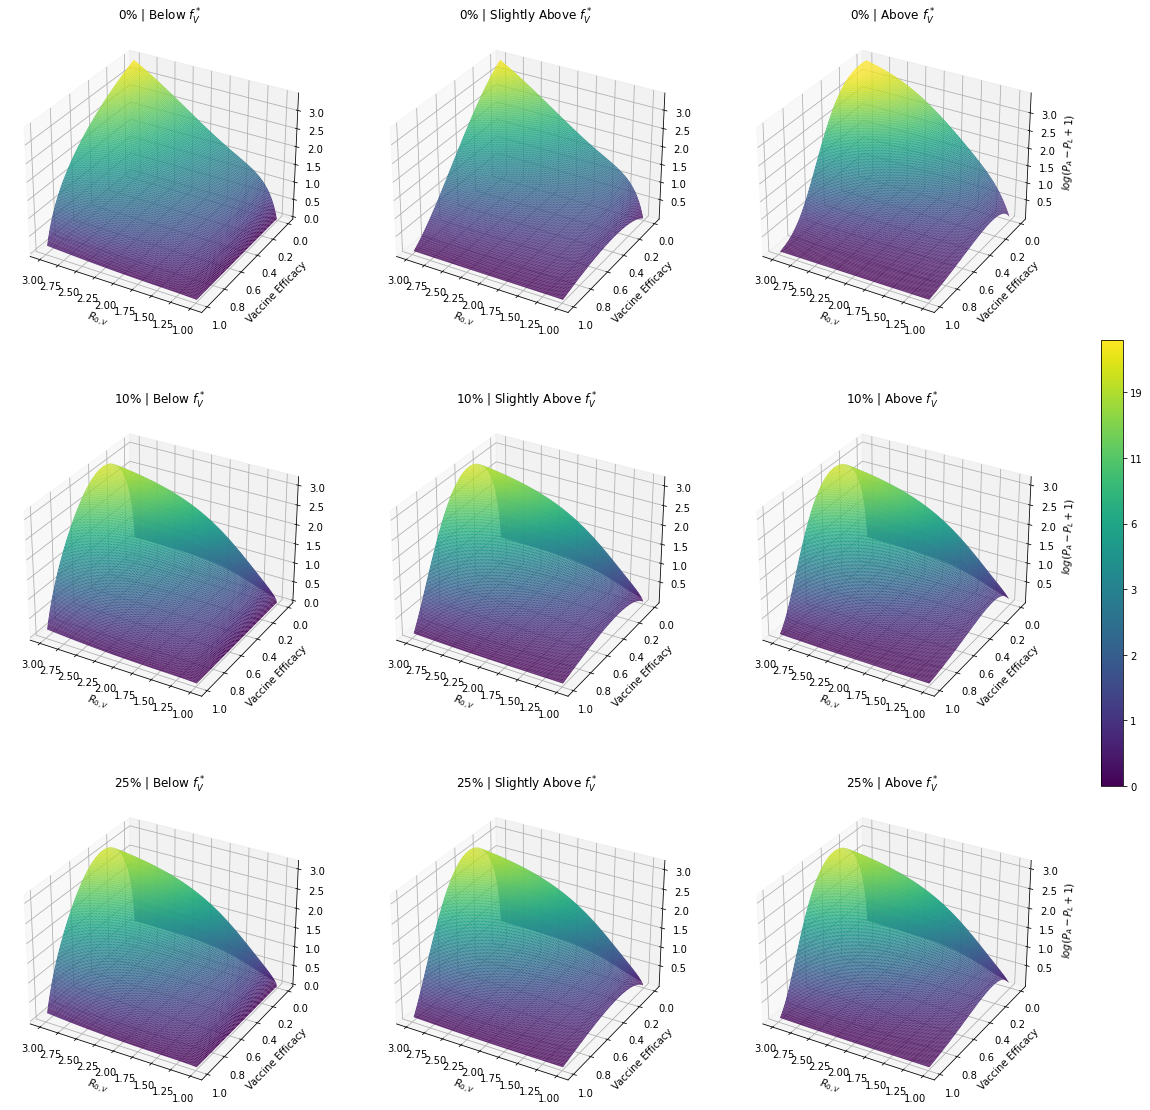

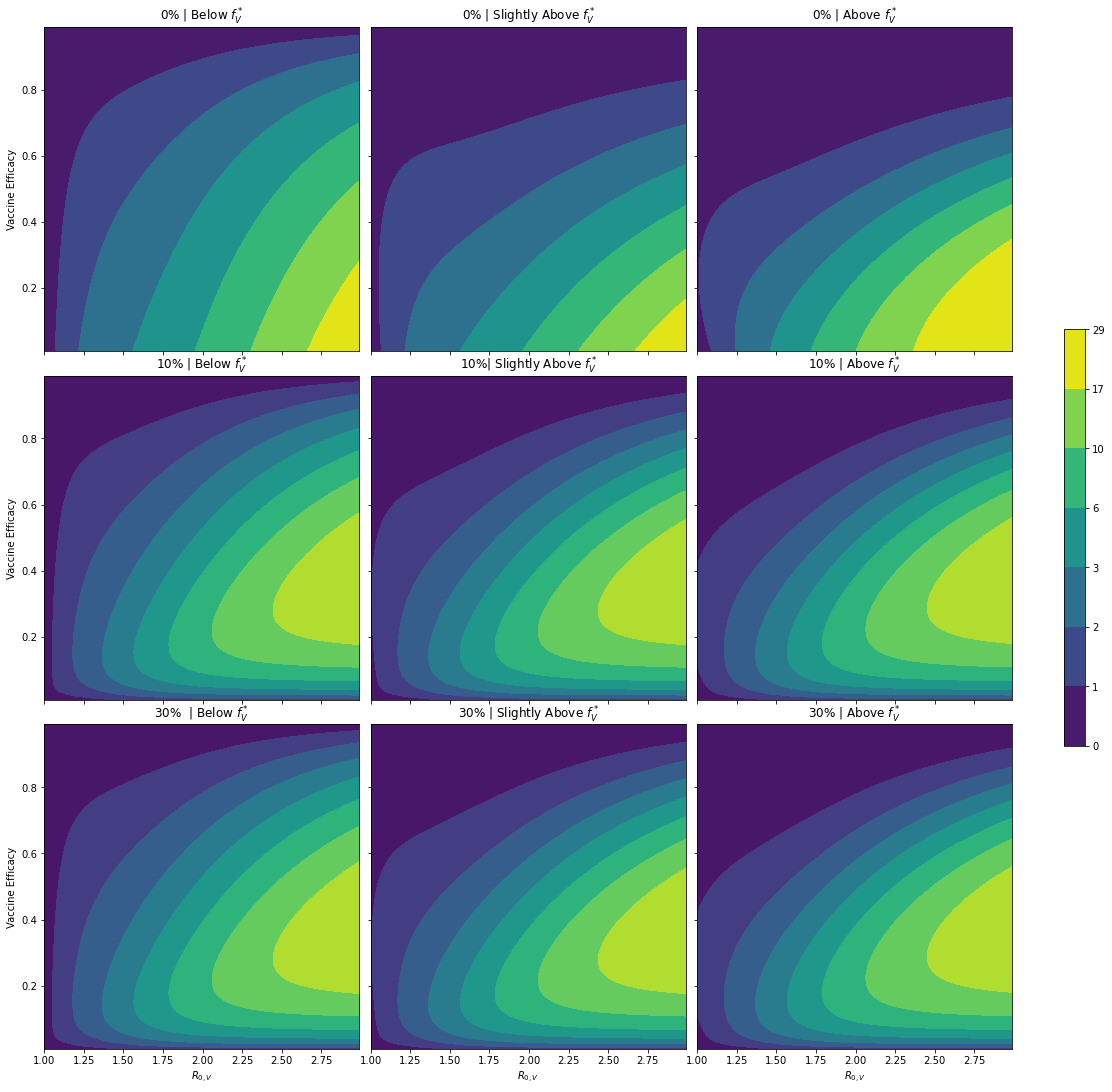

In [66]:
sigma = 1/4; gamma = 1/4; t = np.linspace(0, 300, 301)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_60 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=0, measured=60)
epi10_df_60 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=10, measured=60)
epi25_df_60 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=25, measured=60)

fig_3d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 100 Days After Vaccination

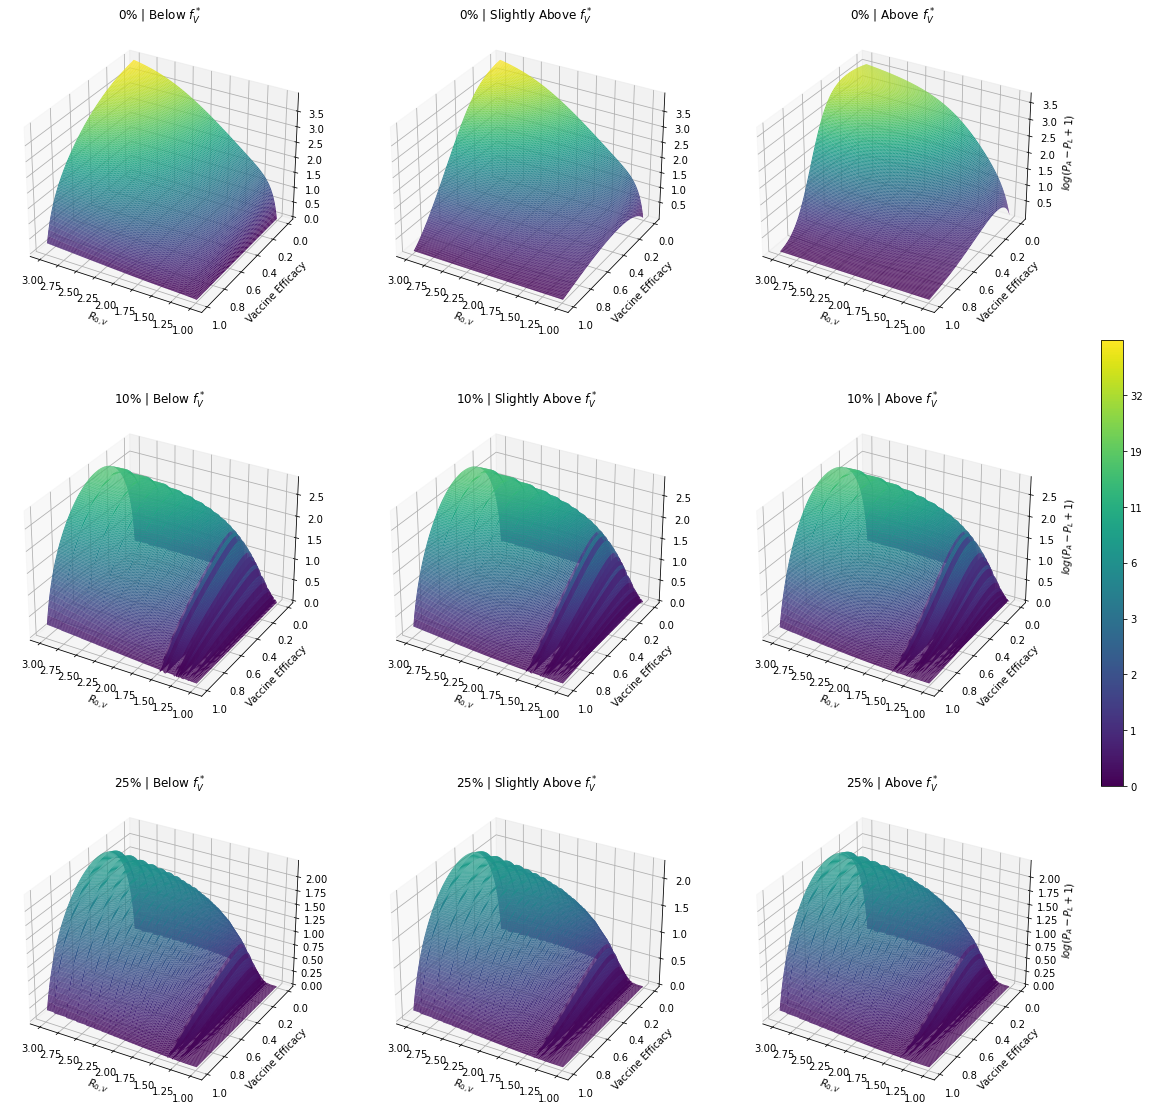

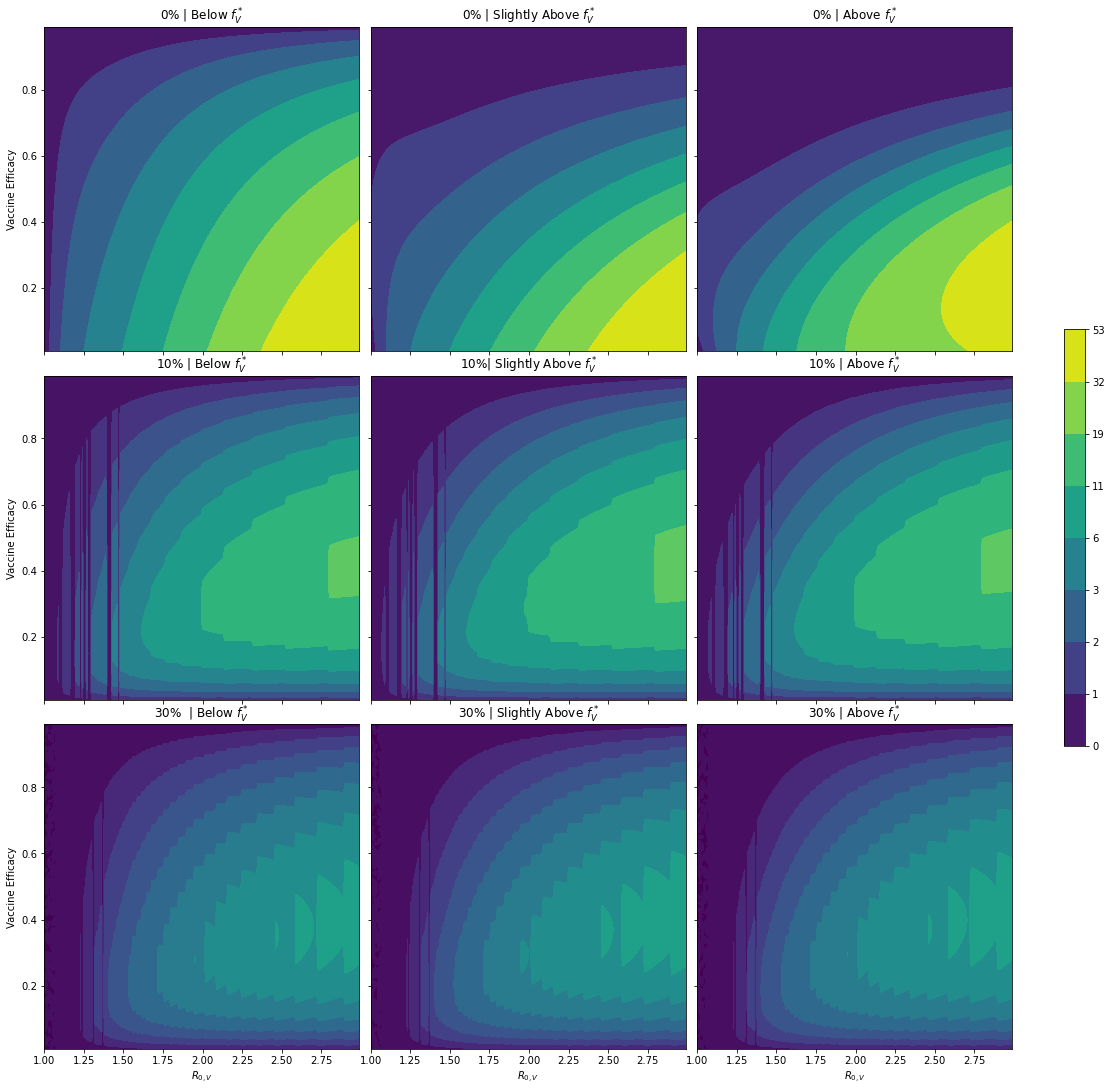

In [ ]:
sigma = 1/4; gamma = 1/4; t = np.linspace(0, 300, 301)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_100 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=0, measured=100)
epi10_df_100 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=10, measured=100)
epi25_df_100 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=25, measured=100)

fig_3d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 300 Days After Vaccination (End of Pandemic)

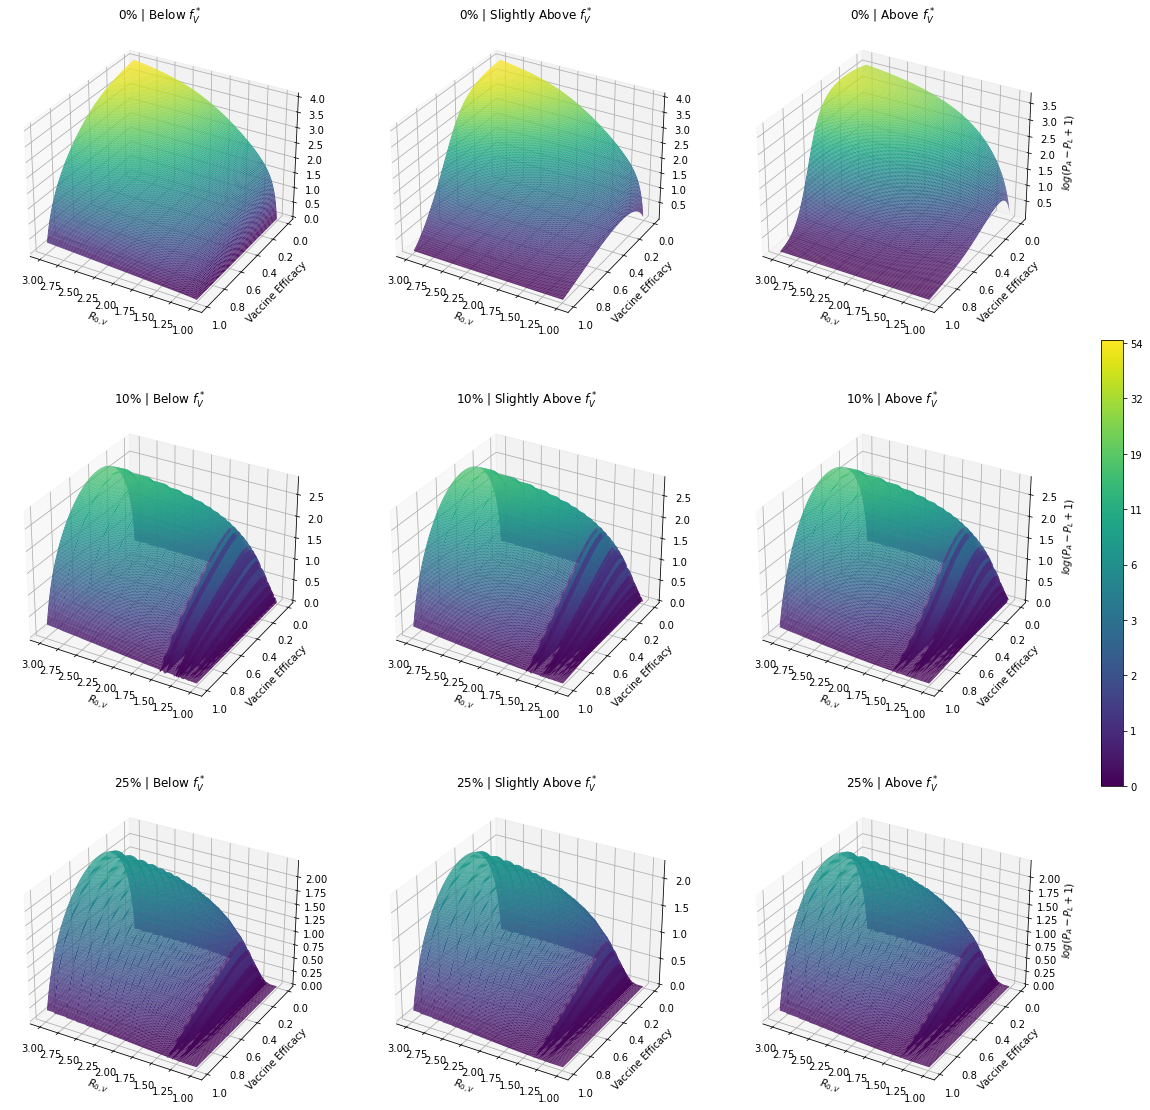

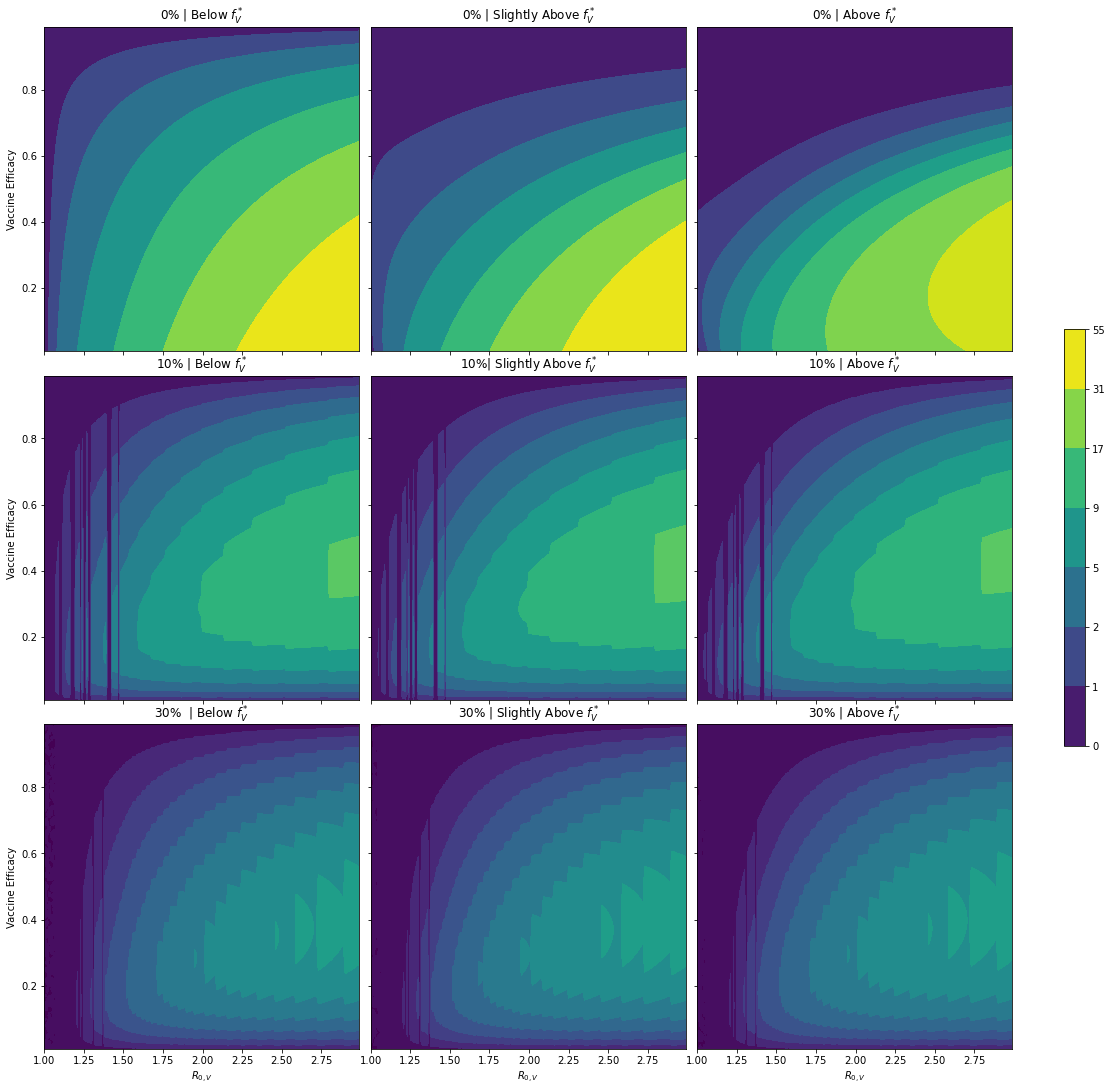

In [ ]:
sigma = 1/4; gamma = 1/4; t = np.linspace(0, 300, 301)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_300 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=0, measured=300)
epi10_df_300 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=10, measured=300)
epi25_df_300 = run_scenarios_size(y0, t, r0s, sigma, gamma, epss, epidemic_size=25, measured=300)

fig_3d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')